In [83]:
# Import necessary libraries
import os
import yaml
import cv2
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from src import data_preprocessing as dp
from src import data_augmentation as da
from src import feature_extraction as fe

In [84]:
# Load configuration
with open("config/config.yaml", 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

raw_dirs = cfg["data"]["raw"]
processed_dirs = cfg["data"]["processed"]
resize_size = tuple(cfg["preprocessing"]["resize_size"])
threshold = cfg["preprocessing"]["threshold"]
classes = cfg["classes"]
augment = cfg["augmentation"]["augment"]
rotation_range = cfg["augmentation"]["rotation_range"]
shift_range = cfg["augmentation"]["shift_range"]
flip_h = cfg["augmentation"]["flip_h"]
flip_v = cfg["augmentation"]["flip_v"]
noise_stddev = cfg["augmentation"]["noise_stddev"]
method = cfg["feature_extraction"]["method"]

# Calculate total images
train_imgs = sum(
    len(os.listdir(os.path.join(processed_dirs[0], class_name)))
    for class_name in classes
)
test_imgs = sum(
    len(os.listdir(os.path.join(processed_dirs[1], class_name)))
    for class_name in classes
)
total_imgs = train_imgs + test_imgs

In [85]:
# Process the images
progress_bar = tqdm(total=total_imgs, desc="Processing images", unit="image")

for raw_dir, processed_dir in zip(raw_dirs, processed_dirs):
    for class_name in classes:
        in_class_dir = os.path.join(raw_dir, class_name)
        out_class_dir = os.path.join(processed_dir, class_name)

        for file in os.listdir(in_class_dir):
            in_file_path = os.path.join(in_class_dir, file)
            image = cv2.imread(in_file_path, cv2.IMREAD_GRAYSCALE)
            processed_image = dp.preprocess_image(
                image,
                resize_size,
                threshold
            )
            out_file_path = os.path.join(out_class_dir, file)
            cv2.imwrite(out_file_path, processed_image)
            progress_bar.update(1)

progress_bar.close()

Processing images: 100%|██████████| 5266/5266 [00:06<00:00, 808.90image/s] 


In [86]:
# Augment the training images
if augment:
    progress_bar = tqdm(total=train_imgs, desc="Augmenting images", unit="image")
    for class_name in classes:
        in_class_dir = os.path.join(processed_dirs[0], class_name)

        for file in os.listdir(in_class_dir):
            in_file_path = os.path.join(in_class_dir, file)
            image = cv2.imread(in_file_path, cv2.IMREAD_GRAYSCALE)
            image = image.astype(np.float32) / 255.0
            augmented_image = da.augment_image(
                image,
                rotation_range,
                shift_range,
                flip_h,
                flip_v,
                noise_stddev
            )
            augmented_image = (augmented_image * 255).astype(np.uint8)
            out_file_path = os.path.join(in_class_dir, file)
            cv2.imwrite(out_file_path, augmented_image)
            progress_bar.update(1)
progress_bar.close()

In [87]:
# Extract features
all_features = []
all_labels = []
all_image_paths = []

if method == 'sift':
    total_imgs = total_imgs * 2
progress_bar = tqdm(total=total_imgs, desc="Processing features", unit="features")

for processed_dir in processed_dirs:
    for class_name in classes:
        in_class_dir = os.path.join(processed_dir, class_name)
        features, image_paths = fe.extract_features(
            in_class_dir,
            method,
            cfg["feature_extraction"],
            progress_bar
        )

        all_features.append(features)
        all_labels.extend([class_name] * features.shape[0])
        all_image_paths.extend(image_paths)

progress_bar.close()

all_features = np.vstack(all_features)
data_dict = {
    "features": all_features,
    "labels": all_labels,
    "image_paths": all_image_paths
}

with open("results/features.pkl", "wb") as f:
    print("Saving pickle file...")
    pickle.dump(data_dict, f)
    print("Done!")

Processing features: 100%|██████████| 5266/5266 [02:17<00:00, 38.28features/s]

Saving pickle file...
Done!


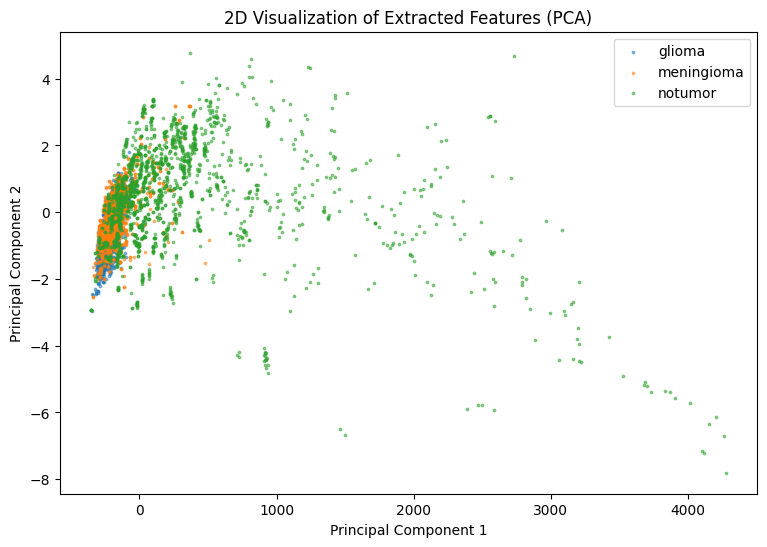

In [88]:
# Load the features from the pickle file
with open("results/features.pkl", "rb") as f:
    data_dict = pickle.load(f)

features = data_dict["features"]
labels = data_dict["labels"]

# Reduce the features to 2 dimensions using PCA
pca = PCA(n_components=2, random_state=42)
features_2d = pca.fit_transform(features)

plt.figure(figsize=(9, 6))
for class_name in classes:
    indices = [i for i, label in enumerate(labels) if label == class_name]
    plt.scatter(
        features_2d[indices, 0],
        features_2d[indices, 1],
        label=class_name,
        alpha=0.5,
        s=3
    )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D Visualization of Extracted Features (PCA)")
plt.legend()
plt.show()